# Сборный проект #2 HR-аналитика

### Описание проекта:

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают решения для предотвращения финансовых потерь и снижения текучести кадров. Компания предоставила данные с характеристиками сотрудников, включая уровень их удовлетворённости работой в компании.

### Цель работы №1

Разработать модель, которая сможет прогнозировать уровень удовлетворённости сотрудников на основе предоставленных данных.

### Цель работы №2

Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from IPython.display import display
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

!pip install phik -q
!pip install yellowbrick
!pip install shap
!pip install scikit-learn==1.1.3 -q
!pip install matplotlib==3.5.2 -q
import phik
from phik import phik_matrix

TEST_SIZE = 0.25
RANDOM_STATE = 42

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (
    roc_auc_score,
    make_scorer
)


## Загрузка данных

In [2]:
try: 
    train_jsr = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', index_col='id')
    X_test = pd.read_csv('/datasets/test_features.csv', index_col='id')
    y_test_jsr  = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', index_col='id')
except:
    train_jsr = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', index_col='id')
    X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
    y_test_jsr  = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv', index_col='id')    

In [3]:
# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.tail())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [4]:
data_info(train_jsr)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB
None


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
457950,technology,junior,high,2,no,no,3,46800,0.45
957499,sales,junior,medium,2,no,no,4,21600,0.68
533318,sales,middle,low,7,no,no,5,24000,0.76
706868,sales,junior,medium,2,no,no,3,24000,0.48
338347,technology,middle,medium,5,no,yes,1,44400,0.18


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


Пропусков в датафрейме:  dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

Количество явных дубликатов в датафрейме: 245


In [5]:
data_info(X_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB
None


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
393147,marketing,junior,low,3,no,no,3,20400
109582,technology,middle,low,3,no,no,2,21600
305653,technology,junior,low,1,no,no,3,14400
160233,technology,middle,low,8,no,no,1,32400
771859,purchasing,middle,medium,1,no,no,4,38400


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Пропусков в датафрейме:  dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Количество явных дубликатов в датафрейме: 557


In [6]:
data_info(y_test_jsr)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB
None


,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


,job_satisfaction_rate
id,
405257,0.28
370925,0.21
857722,0.39
303402,0.26
648995,0.62


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


Пропусков в датафрейме:  job_satisfaction_rate    0
dtype: int64

Количество явных дубликатов в датафрейме: 1902


#### Промежуточный вывод по загрузке и осмотру данных первой задачи

* Почти все данные получены правильно, object будет заменен на category
- судя по описанию данных, supervisor_evaluation должен быть object признаком
- в тренировочном и тестовом датасетах есть несколько пропусков, рассмотрим подробнее, что с ними делать
- медиана не сильно отличается от среднего( не больше 10%), думаю можно обойтись без обработки от выбросов
- явных дубликатов много во всех выборках, позже мы их удалим
- названия колонок колонок в нижнем регистре

## Предобработка данных

Сначала преобразуем колонки типа object в category. Для этого создадим список и пройдемся по датафреймам через цикл.

In [7]:
cat_col_train = ['dept', 'level', 'workload','last_year_promo', 'last_year_violations', 'supervisor_evaluation']
num_col_train = ['employment_years', 'salary', 'job_satisfaction_rate']

In [8]:
for col in cat_col_train:
    train_jsr[col] = train_jsr[col].astype('category')
    X_test[col] = X_test[col].astype('category')

Теперь при помощи созданного списка пройдемся по всем столбцам тренировочной и тестовой выборок, проверив на неявные дубликаты.

In [9]:
for col in cat_col_train:
    print(col)
    display(train_jsr[col].sort_values().unique())
    print()
    display(X_test[col].sort_values().unique())

dept


['hr', 'marketing', 'purchasing', 'sales', 'technology', NaN]
Categories (5, object): ['hr', 'marketing', 'purchasing', 'sales', 'technology']

[' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology', NaN]
Categories (6, object): [' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology']

level


['junior', 'middle', 'sinior', NaN]
Categories (3, object): ['junior', 'middle', 'sinior']

['junior', 'middle', 'sinior', NaN]
Categories (3, object): ['junior', 'middle', 'sinior']

workload


['high', 'low', 'medium']
Categories (3, object): ['high', 'low', 'medium']

[' ', 'high', 'low', 'medium']
Categories (4, object): [' ', 'high', 'low', 'medium']

last_year_promo


['no', 'yes']
Categories (2, object): ['no', 'yes']

['no', 'yes']
Categories (2, object): ['no', 'yes']

last_year_violations


['no', 'yes']
Categories (2, object): ['no', 'yes']

['no', 'yes']
Categories (2, object): ['no', 'yes']

supervisor_evaluation


[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

[1, 2, 3, 4, 5]
Categories (5, int64): [1, 2, 3, 4, 5]

#### В тренировочной выборке train_jsr
* В dept есть Nan значения
- в level аналогично
- workload, last year promo\violations все чисто
- supervisor_eval так же все чисто

#### В тестовой выборке X_test:

* В dept есть Nan и строки заполненные пустой строкой
- level есть Nan значения
- workload есть строки заполненные пустой строкой
- supervisor_eval так же все чисто

Еще у меня от "sinior" болят глаза, поэтому изменю на "senior".

In [10]:
# обработаем тестовую выборку
X_test['dept'] = X_test['dept'].replace(' ', np.nan)
X_test['workload']= X_test['workload'].replace(' ', np.nan)

# сделаем также замену sinior в двух фреймах
train_jsr['level'] = train_jsr['level'].replace('sinior', 'senior')
X_test['level'] = X_test['level'].replace('sinior', 'senior')

## Исследовательский анализ данных

Сначала посмотрим числовые признаки. Построим для них гистограмму и боксплот. Для категориальных воспользуемся барплотом. По идее, графики train_jsr и X_test должны будут выглядить одинаково, это предстоит проверить.

#### EDA тренировочной выборки

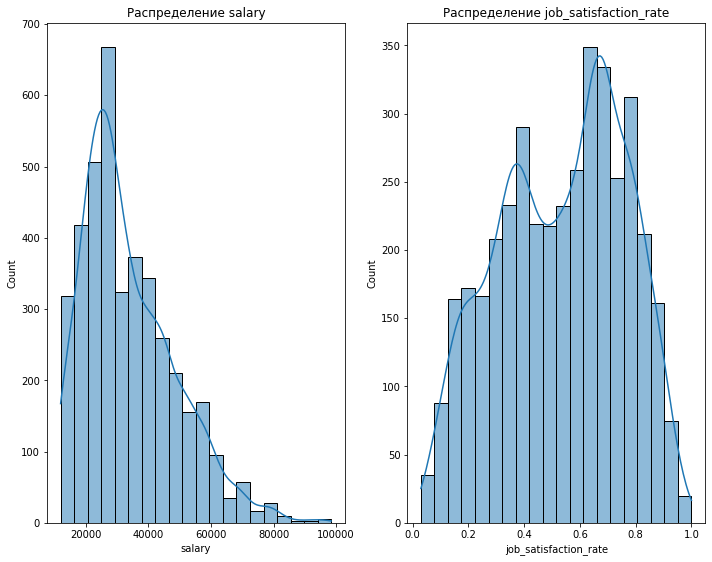

In [11]:
temp = ['salary', 'job_satisfaction_rate']
# Посмотрим на гистограммы train_jsr
plt.figure(figsize=(20, 15))
for i, col in enumerate(temp, 1):
    plt.subplot(2, 4, i)
    sns.histplot(train_jsr[col], kde=True, bins=20)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

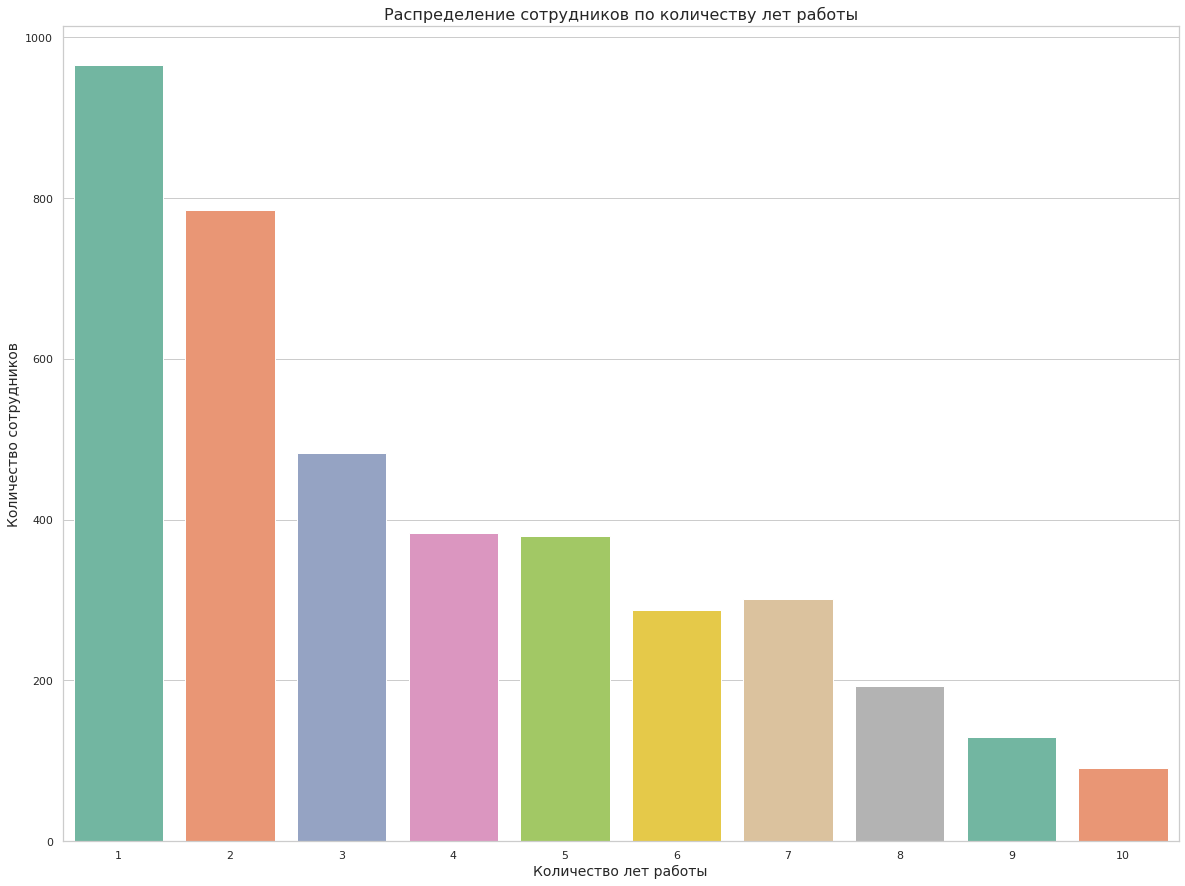

In [12]:
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))  # Размер графика
sns.countplot(x='employment_years', data=train_jsr, palette='Set2')
plt.title('Распределение сотрудников по количеству лет работы', fontsize=16)
plt.xlabel('Количество лет работы', fontsize=14)
plt.ylabel('Количество сотрудников', fontsize=14)
# Отображение графика
plt.show()

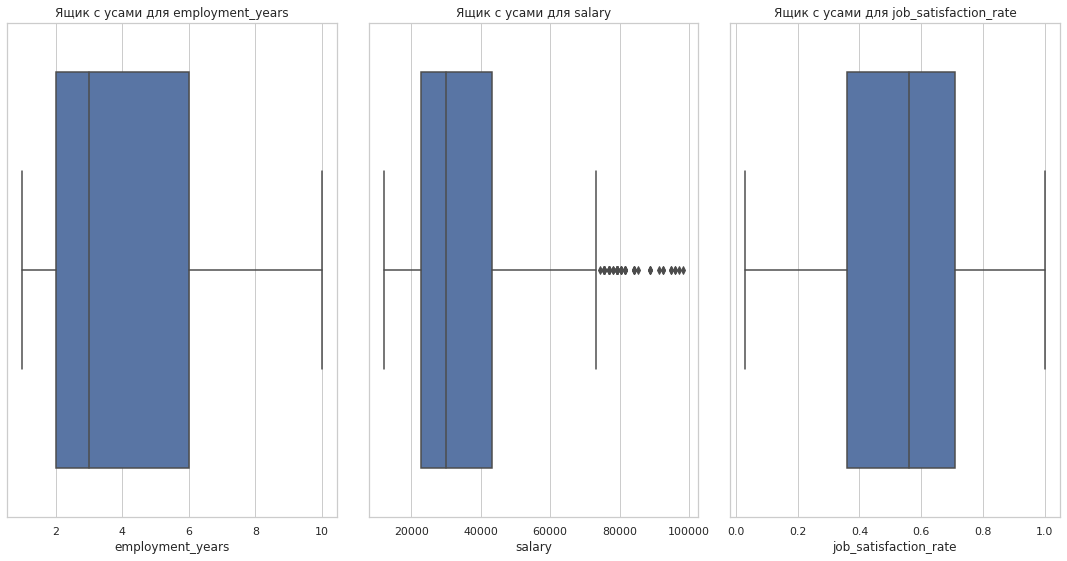

In [13]:
# бохплот train_jsr
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col_train, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=train_jsr[col])
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

Складывается ощущение, будто большие зарплаты это выбросы. Но в целом, не думаю что они сильно повлияют на результат. Для тестовой выборки графики выглядят аналогично.

#### Исследование категориальных признаков

Построим столбиковую диаграмму для категориальных признаков.

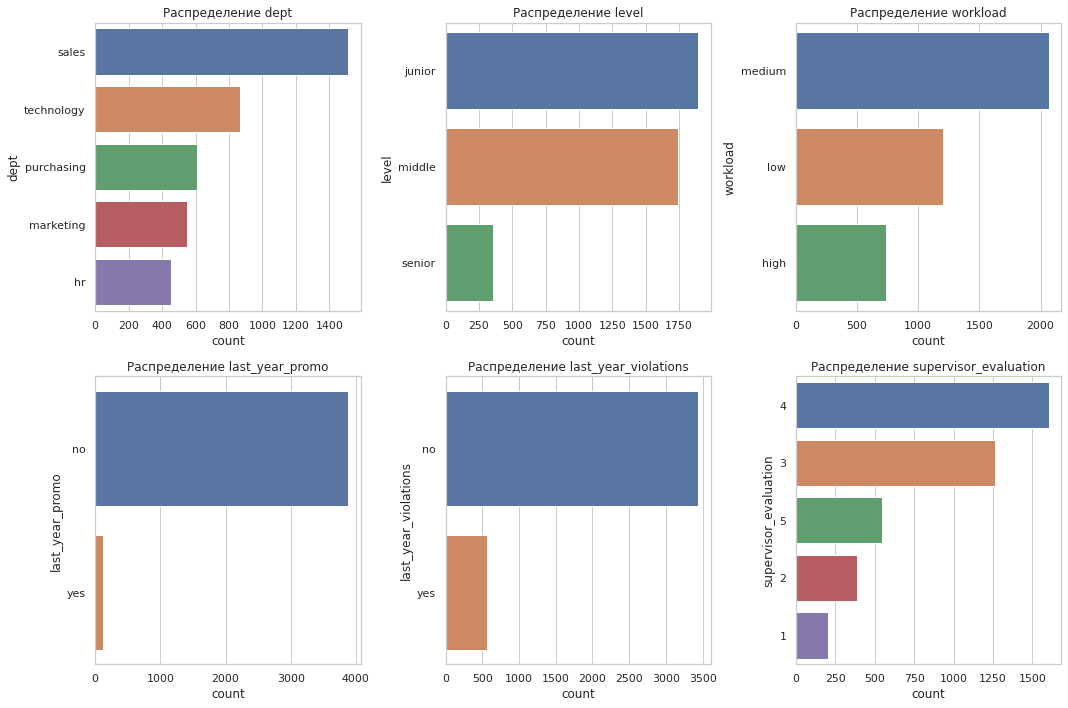

In [14]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col_train, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=train_jsr[col], order=train_jsr[col].value_counts().index)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

#### Промежуточный вывод по категориальным признакам

Изучив диаграммы, мы видим, что среди сотрудников компании по отделам преобладают продажники, по уровню занимаемой должности - junior и middle, по загруженности больше всего сотрудников со средним уровнем загруженности. Повышение было только у малого процента сотрудников, а нарушения трудового договора выявлены примерно у 15% сотрудников. Распределение данных в тестовой и тренировочной выборках практически идентичное.

Для подготовки категориальных данных мы будем использовать кодирование, для признаков с нарушениями и повышениями можно использовать OneHotEncoder, для остальных OrdinalEncoder, причем надо учесть, что уровень должности и уровень загруженности это ранговые признаки.

### Корелляционный анализ

Воспользуемся библиотекой phik и посчитаем корелляцию Спирмана. Исследуем тренировочный датасет на мультиколлинеарность.

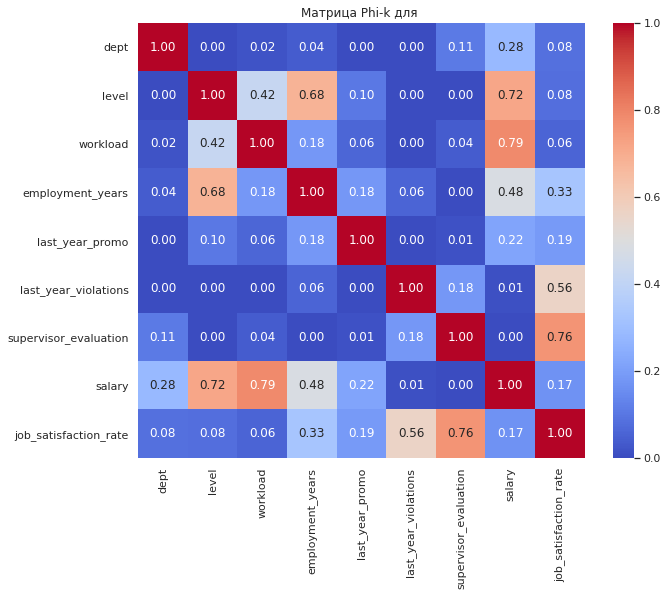

In [15]:
# собираем матрицу корелляции
plt.figure(figsize=(10, 8))
phik_corr_matrix = train_jsr.phik_matrix(temp)
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица Phi-k для ')
plt.show()


#### Промежуточный вывод по тренировочной выборке

Выбросов и аномалий в данных не обнаружено. Между некоторыми признаками есть связь, но она не превышает 0.9, так что менять ничего не будем. Так же было проведено сравнение тестовой и тренировочной выборки - выглядят практически одинаково.

#### EDA тестовой выборки

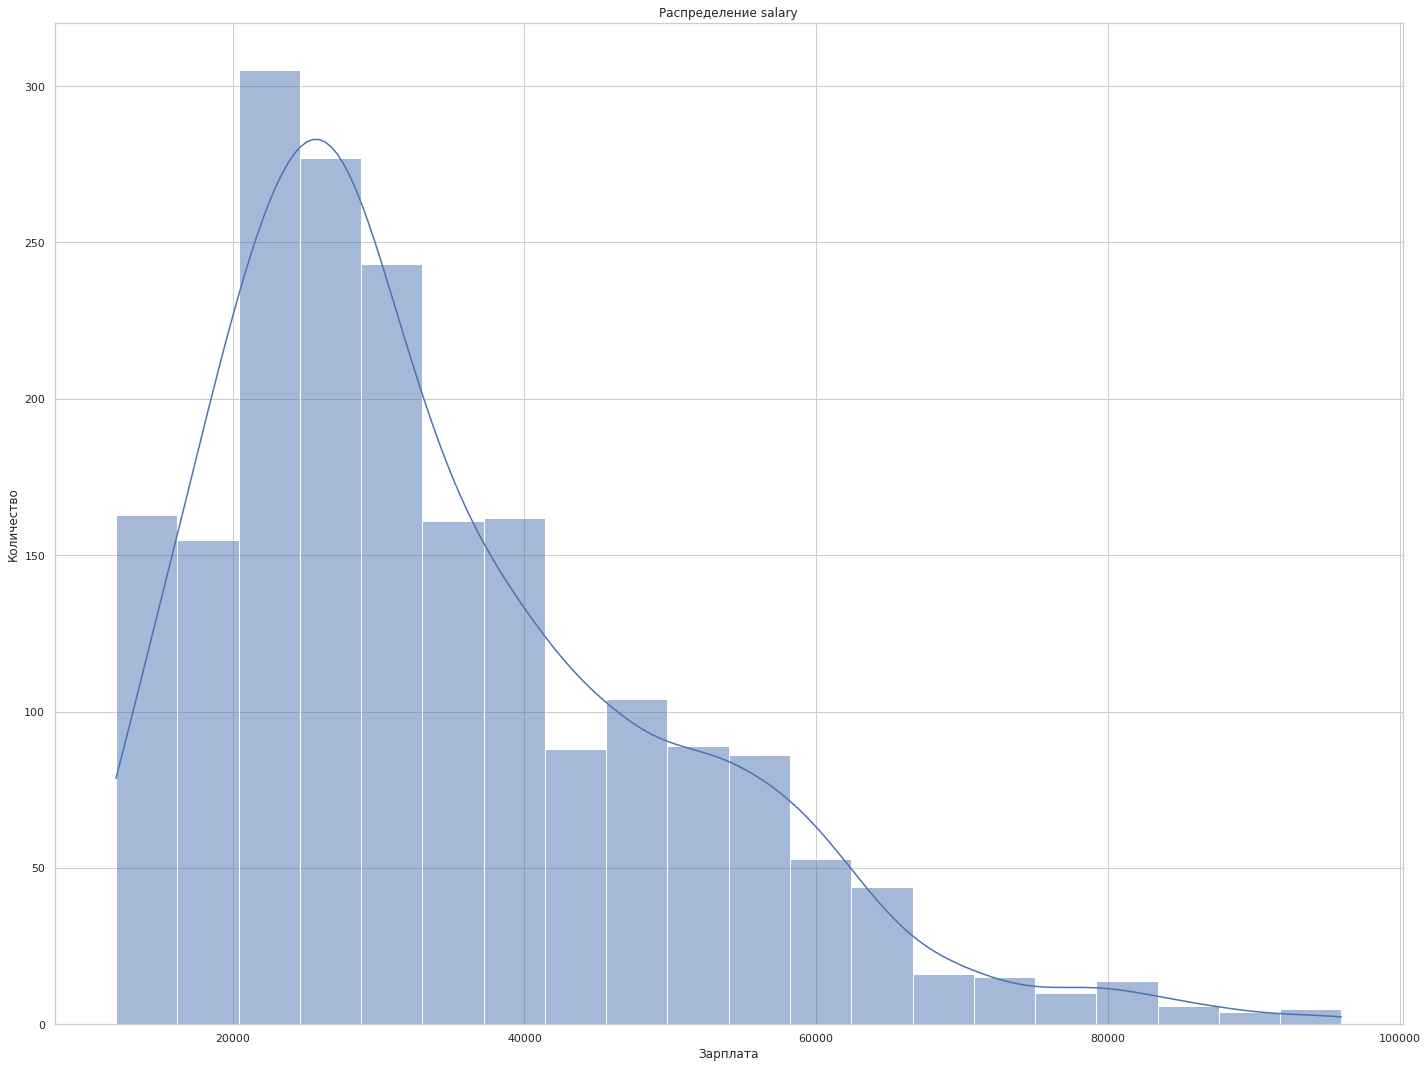

In [16]:
plt.figure(figsize=(20, 15))
sns.histplot(X_test['salary'], kde=True, bins=20)
plt.title(f'Распределение salary')
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

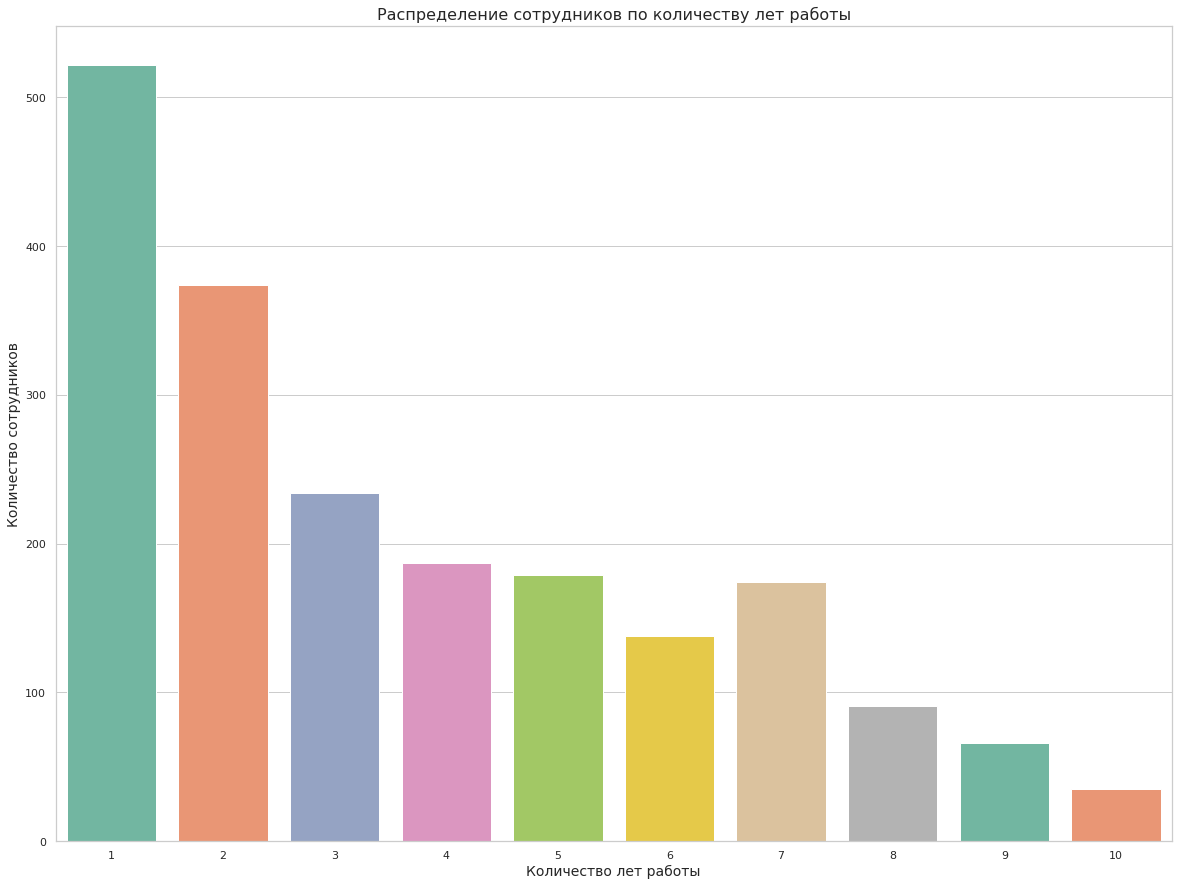

In [17]:
# строим отдельно распределние для работников для тестовой выборки
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))  # Размер графика
sns.countplot(x='employment_years', data=X_test, palette='Set2')
plt.title('Распределение сотрудников по количеству лет работы', fontsize=16)
plt.xlabel('Количество лет работы', fontsize=14)
plt.ylabel('Количество сотрудников', fontsize=14)
# Отображение графика
plt.show()

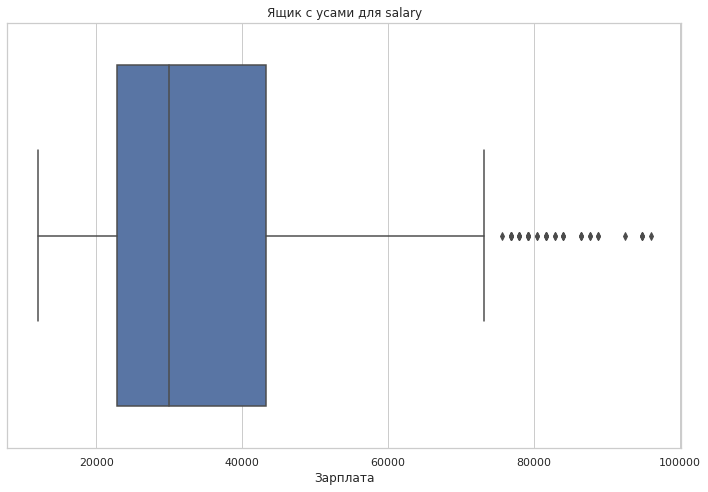

In [18]:
# бохплот X_test
plt.figure(figsize=(10, 7))
sns.boxplot(x=X_test['salary'])
plt.title(f'Ящик с усами для salary')
plt.xlabel('Зарплата')
plt.tight_layout()
plt.show()

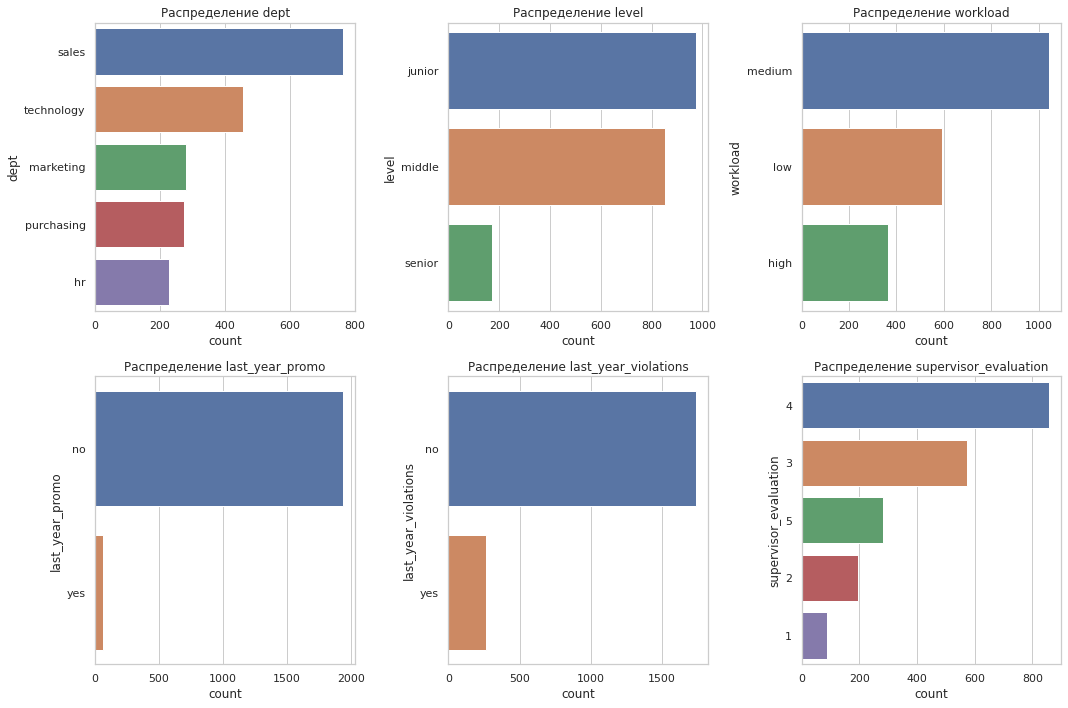

In [19]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col_train, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=X_test[col], order=X_test[col].value_counts().index)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

In [20]:
# удалим явные дубликаты из тренировочной и тестовой выборок

train_jsr.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...
424345,hr,senior,high,6,no,no,4,80400,0.88
855240,sales,junior,medium,2,no,no,3,20400,0.27
533318,sales,middle,low,7,no,no,5,24000,0.76


## Подготовка данных и обучение модели

Вся подготовка будет проведена через пайпланы с дополнительной подготовкой признаков.

Для подготовки признаков будем использовать:
* MinMaxScaler/StandartScaler для стобцов employment_years, salary
- OrdinalEncoder для столбцов supervisor_evaluation, level, workload
- OneHotEncoder для столбцов dept, last_year_promo, last_year_violations

Также создадим новую метрику SMAPE в виде функции.

In [21]:
# подготовим признаки
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

# выделим X_train y_train
X_train = train_jsr.drop(['job_satisfaction_rate'], axis=1)
y_train = train_jsr['job_satisfaction_rate']

In [22]:
# собираем пайплайны
# шаг 1
# Создадим пайплайн для подготовки признаков из ohe_columns
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')        
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown ='ignore')
        )
    ]
)

In [23]:
# шаг 2
# Создадим пайплайн для подготовки признаков из ord_columns
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

#шаг 3
# Создадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

#шаг 4
# Создаем итоговый пайплайн для подготовки данных и моделирования
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

### Обучение модели для задачи 1

In [24]:
param_grid = [
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 13),
        'models__max_features': range(5, 13)
    },
 
    {
        'models': [LinearRegression()],
         
    }
]

# напишем фукнцию для использования метрики SMAPE
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(np.abs(y_true-y_pred)/((np.abs(y_true) + np.abs(y_pred))/2))

smape_scorer = make_scorer(smape_score, greater_is_better = False)

In [25]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv           = 5,
    scoring      = smape_scorer,
    random_state = RANDOM_STATE,
    n_jobs       = -1
)

# обучаем модель на тренировочной выборке
randomized_search.fit(X_train, y_train)

# сразу получим лучшую модель, параметры, метрику
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

Лучшей моделью на кросс-валидации оказалось дерево решений, с глубиной 12 и числом признаков 10. Теперь проверим, как лучшая модель проявит себя на тестовой выборке. И рассчитаем метрику SMAPE.

In [26]:
y_test_jsr = y_test_jsr.sort_index()
X_test = X_test.sort_index()
predictions = randomized_search.predict(X_test)
print ("Метрика SMAPE равна: ", smape_score(y_test_jsr['job_satisfaction_rate'], predictions))

Метрика SMAPE равна:  14.210850843243314


In [27]:
# проверим модель на адекватность
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
preds = dummy_model.predict(X_test)
print('Метрика SMAPE, если бы мы заполняли средними значениями: ', smape_score(y_test_jsr['job_satisfaction_rate'], preds))

Метрика SMAPE, если бы мы заполняли средними значениями:  38.21941812666904


#### Промежуточный вывод по задаче

В данном шаге была найдена и обучена лучшая модель по предсказанию уровня удовлетворённости сотрудника работой.  После проверки на тестовой выборке значение метрики осталось примерно на том же уровне, значит модель работает хорошо. Значение метрики на тестовой выборке составляет 14.21, что отлично, ведь для неё необходимо значение меньше 15.

Лучшей моделью стала DecisionTreeRegressor(max_depth=12, max_features=10, random_state=42). Данная модель справилась лучше линейной регрессии, так как лучше справляется при нелинейной зависимости признаков.

# Задача 2: предсказание увольнения сотрудника из компании

В этой задаче целевым признаком будет quit.
Приступим к загрузке данных

In [28]:
try:
    train_jsr_2 = pd.read_csv('/datasets/train_quit.csv', index_col='id')
    X_test_2 = pd.read_csv('/datasets/test_features.csv', index_col='id')
    y_test_jsr_2 = pd.read_csv('/datasets/test_target_quit.csv', index_col='id')
except:
    train_jsr_2=pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', index_col='id')
    X_test_2=pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
    y_test_jsr_2=pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', index_col='id')

In [29]:
# действуем аналогично первой задаче
data_info(train_jsr_2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB
None


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
588809,sales,junior,medium,4,no,no,3,26400,no
672059,sales,middle,high,9,no,no,4,52800,no
536432,purchasing,junior,low,2,no,yes,4,12000,yes
692133,purchasing,middle,medium,2,no,no,4,33600,no
853842,sales,junior,medium,2,no,no,3,27600,yes


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Пропусков в датафрейме:  dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Количество явных дубликатов в датафрейме: 1413


In [30]:
data_info(X_test_2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB
None


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
393147,marketing,junior,low,3,no,no,3,20400
109582,technology,middle,low,3,no,no,2,21600
305653,technology,junior,low,1,no,no,3,14400
160233,technology,middle,low,8,no,no,1,32400
771859,purchasing,middle,medium,1,no,no,4,38400


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Пропусков в датафрейме:  dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Количество явных дубликатов в датафрейме: 557


In [31]:
data_info(y_test_jsr_2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB
None


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


,quit
id,
836109,yes
180999,yes
746018,no
247658,no
460332,yes


,quit
count,2000
unique,2
top,no
freq,1436


Пропусков в датафрейме:  quit    0
dtype: int64

Количество явных дубликатов в датафрейме: 1998


#### Промежуточные выводы по загрузке данных

* train_jsr_2 пропусков в данных нет, явные дубликаты отсутствуют, названия колонок в нижнем регистре, требуется преобразование столбцов object -> category, а также столбец quit -> category
- X_test_2 есть пара пропусков, явные дубликаты отсутствуют, медианное значение близко к среднему, скорее всего выбросов нет
- y_test_jsr_2 также требуется преобразование столбцов, в остальном все нормально, данных достаточно для предсказания.

## Предобработка для задачи 2

Преобразуем object -> category. Также составляем списки с категориями по аналогии с предыдущей задачей.

In [32]:
cat_col_train2 = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
cat_col_train_w_quit = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
num_col_train2 =['employment_years','supervisor_evaluation', 'salary']

In [33]:
for col in cat_col_train2:
    train_jsr_2[col] = train_jsr_2[col].astype('category')
    X_test_2[col] = X_test_2[col].astype('category')
    
train_jsr_2['quit'] = train_jsr_2['quit'].astype('category')
y_test_jsr_2['quit'] = y_test_jsr_2['quit'].astype('category')

Теперь исследуем на пропуски.

In [34]:
for col in cat_col_train2:
    print(col)
    display(train_jsr_2[col].sort_values().unique())
    print()
    display(X_test_2[col].sort_values().unique())

dept


['hr', 'marketing', 'purchasing', 'sales', 'technology']
Categories (5, object): ['hr', 'marketing', 'purchasing', 'sales', 'technology']

[' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology', NaN]
Categories (6, object): [' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology']

level


['junior', 'middle', 'sinior']
Categories (3, object): ['junior', 'middle', 'sinior']

['junior', 'middle', 'sinior', NaN]
Categories (3, object): ['junior', 'middle', 'sinior']

workload


['high', 'low', 'medium']
Categories (3, object): ['high', 'low', 'medium']

[' ', 'high', 'low', 'medium']
Categories (4, object): [' ', 'high', 'low', 'medium']

last_year_promo


['no', 'yes']
Categories (2, object): ['no', 'yes']

['no', 'yes']
Categories (2, object): ['no', 'yes']

last_year_violations


['no', 'yes']
Categories (2, object): ['no', 'yes']

['no', 'yes']
Categories (2, object): ['no', 'yes']

Резюме:
1. train_jsr_2
* level - опечатка
2. X_test_2
* dept - пустая строка + Nan
- level - опечатка + Nan
- workload - пустая строка

Остальные колонки чисты.

In [35]:
#обработаем тренировочную выборку
train_jsr_2['level'] = train_jsr_2['level'].replace('sinior', 'senior')

# обработаем тестовую выборку
X_test_2['dept'] = X_test_2['dept'].replace(' ', np.nan)
X_test_2['workload']= X_test_2['workload'].replace(' ', np.nan)

# сделаем также замену sinior в тестовой выборке

X_test_2['level'] = X_test_2['level'].replace('sinior', 'senior')

## Исследовательский анализ данных(з2)

Итак, наша задача в этом разделе: составить портрет сотрудника, склонного к скорому увольнению. Посмотрим есть ли зависимость от отдела, зарплаты или удовлетворенности сотрудника работой.

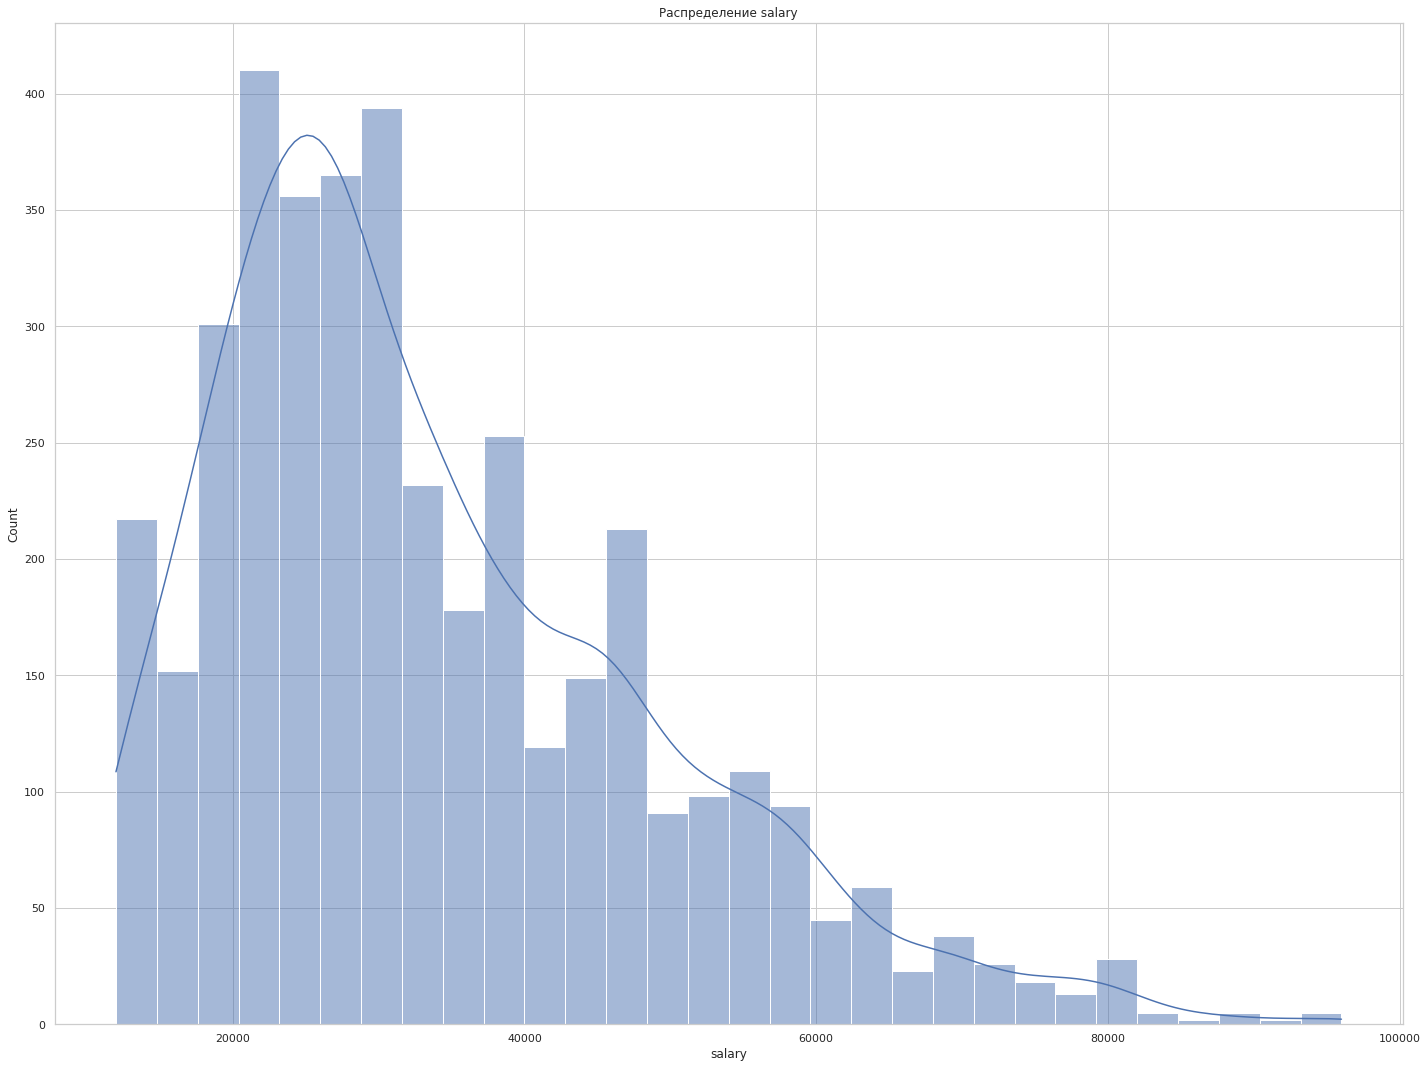

In [36]:
# Посмотрим на гистограммы train_jsr
plt.figure(figsize=(20, 15))
sns.histplot(train_jsr_2['salary'], kde=True, bins=30)
plt.title(f'Распределение salary')
plt.tight_layout()
plt.show()

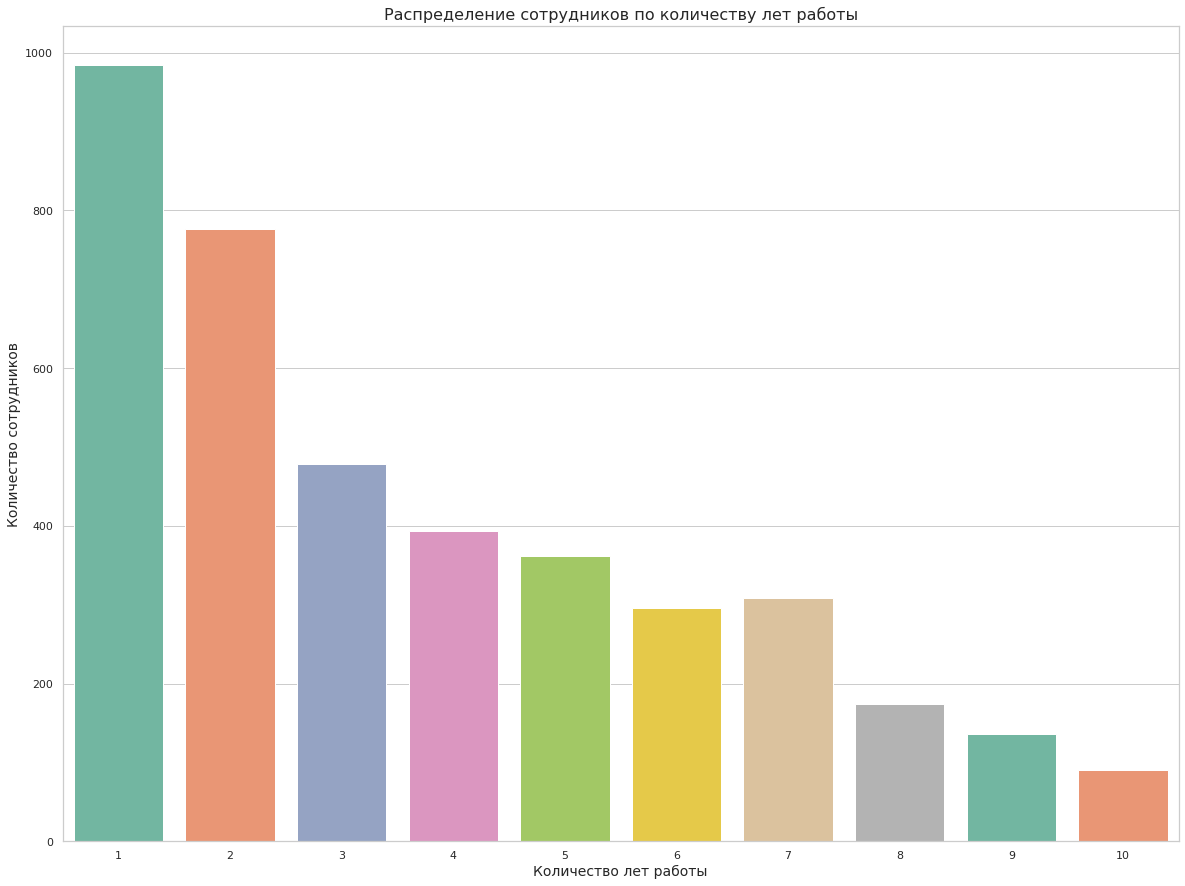

In [37]:
# так как employment_years дискретный признак, посторим столбиковую диаграмму
sns.set(style='whitegrid')
plt.figure(figsize=(20, 15))  # Размер графика
sns.countplot(x='employment_years', data=train_jsr_2, palette='Set2')
plt.title('Распределение сотрудников по количеству лет работы', fontsize=16)
plt.xlabel('Количество лет работы', fontsize=14)
plt.ylabel('Количество сотрудников', fontsize=14)
# Отображение графика
plt.show()

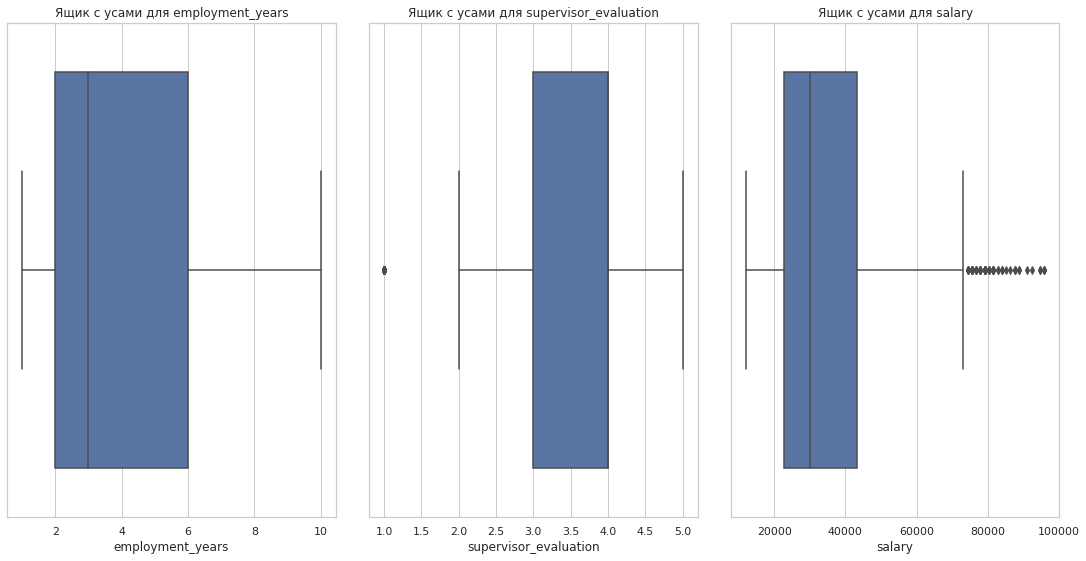

In [38]:
# бохплот train_jsr_2
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col_train2, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=train_jsr_2[col])
    plt.title(f'Ящик с усами для {col}')
plt.tight_layout()
plt.show()

Проанализируем категориальные признаки.

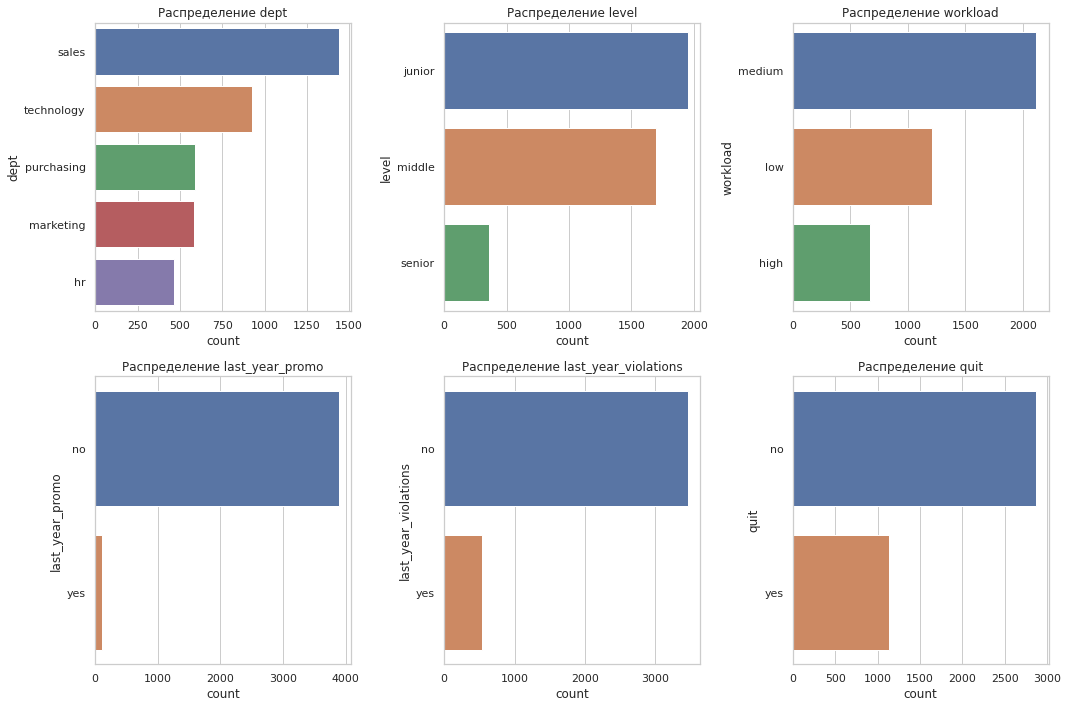

In [39]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col_train_w_quit, 1):
    plt.subplot(2, 3, i)
    sns.countplot(y=train_jsr_2[col], order=train_jsr_2[col].value_counts().index)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()

### Корелляционный анализ(з2)

Проверим тренировочный датасет на мультиколлинеарность.

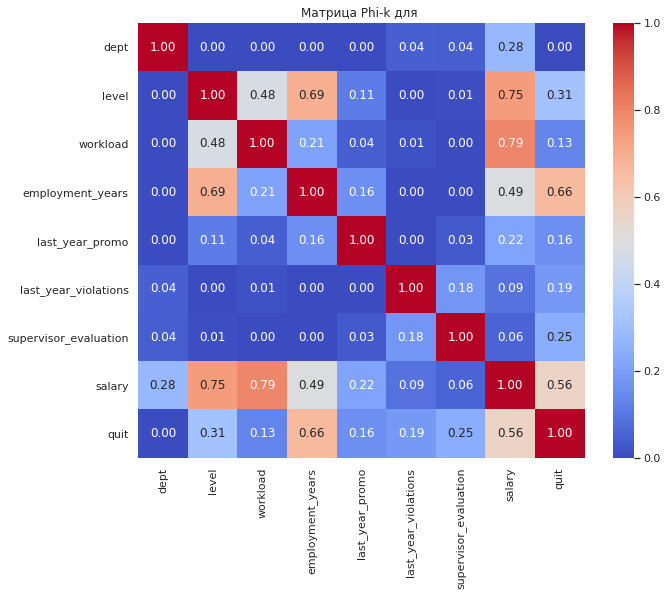

In [40]:
# переназначим
num_col_train2 =['supervisor_evaluation', 'salary']
# собираем матрицу корелляции
plt.figure(figsize=(10, 8))
phik_corr_matrix2 = train_jsr_2.phik_matrix(num_col_train2)
sns.heatmap(phik_corr_matrix2, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица Phi-k для ')
plt.show()

Мультиколлинеарности между признаками не обнаружено.

Теперь попробуем составить портрет "уволившегося сотрудника".

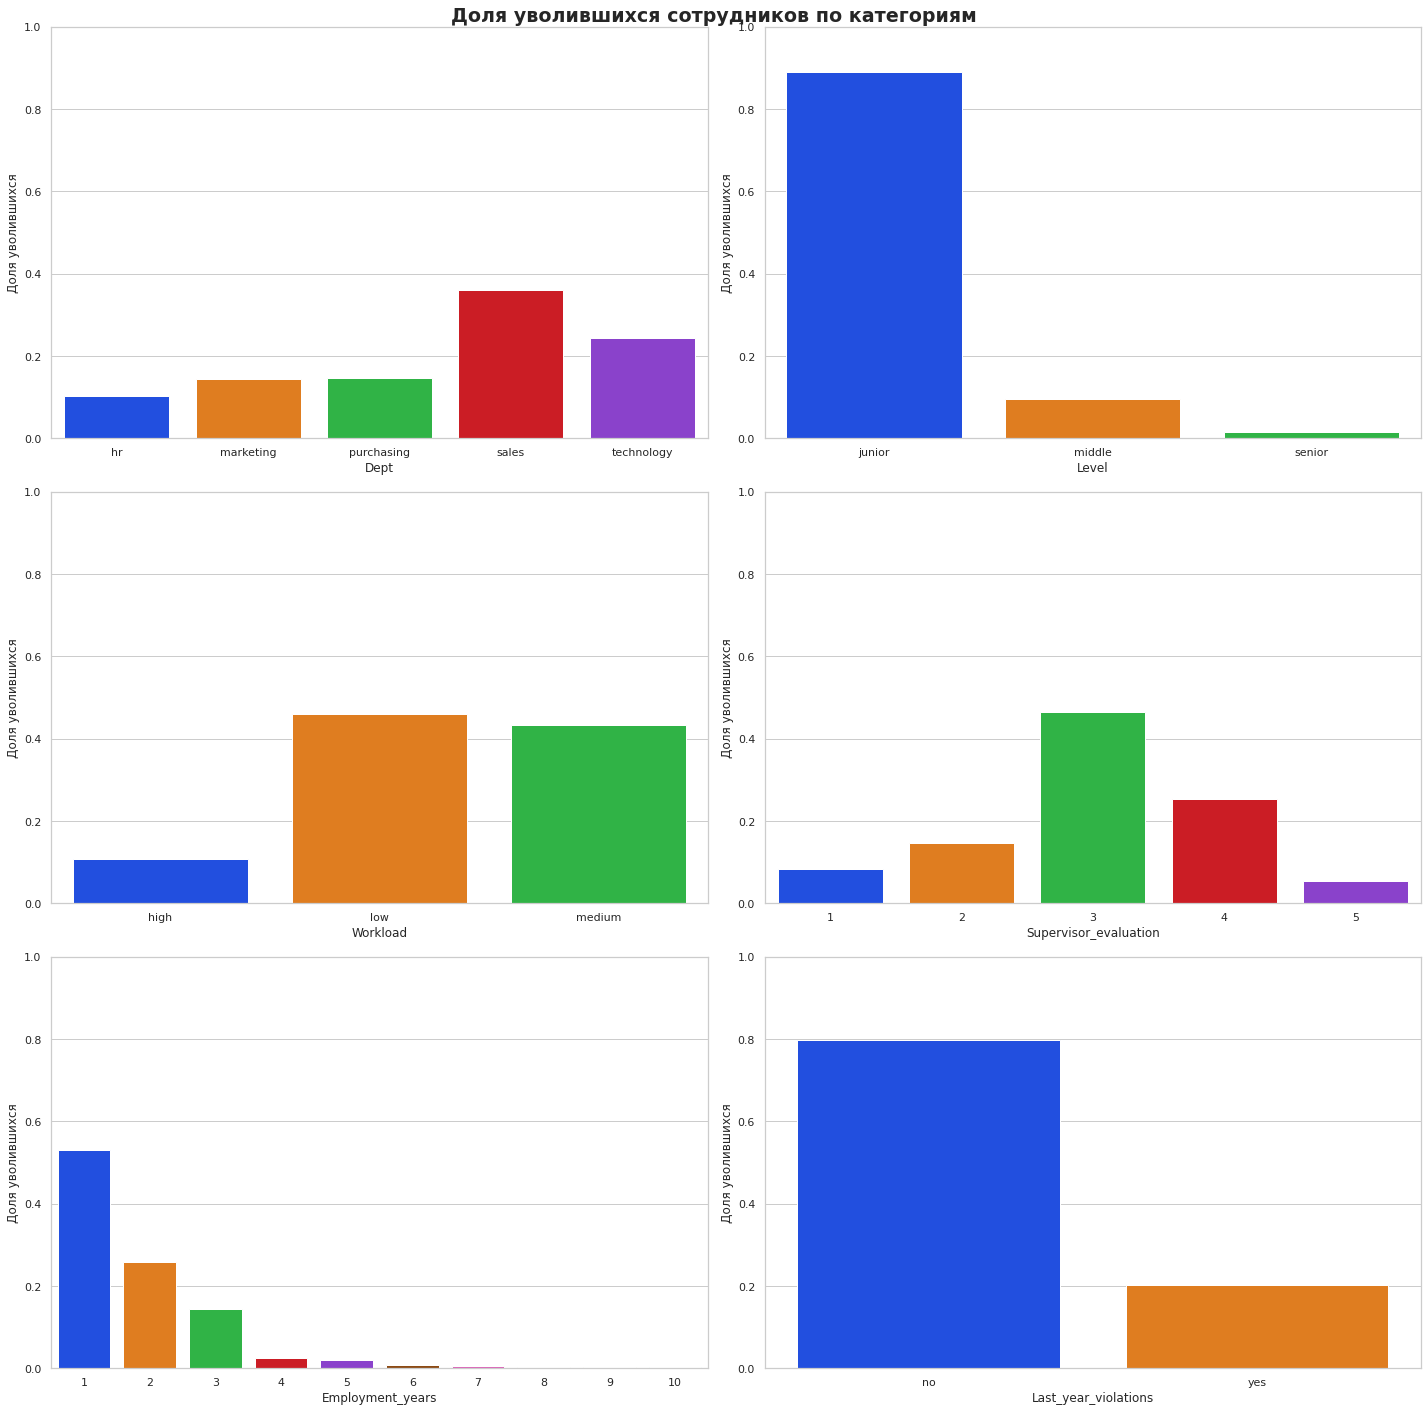

In [41]:
# Список признаков для анализа
features = ['dept', 'level', 'workload', 'supervisor_evaluation', 'employment_years', 'last_year_violations']

# Настройка сетки графиков
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
plt.suptitle('Доля уволившихся сотрудников по категориям', fontsize=19, fontweight='bold')

# Фильтруем данные уволившихся сотрудников
quit_data = train_jsr_2[train_jsr_2['quit'] == 'yes']

# Построение графиков
for i, feature in enumerate(features):
    row = i // 2  
    col = i % 2   
    
    # Считаем доли уволившихся для каждой категории признака
    quit_ratio = quit_data[feature].value_counts(normalize=True).sort_index()

    sns.barplot(x=quit_ratio.index, y=quit_ratio.values, palette='bright', ax=axes[row, col])
    axes[row, col].set(xlabel=feature.capitalize(), ylabel='Доля уволившихся')
    axes[row, col].set_ylim(0, 1)

plt.tight_layout()
plt.show()

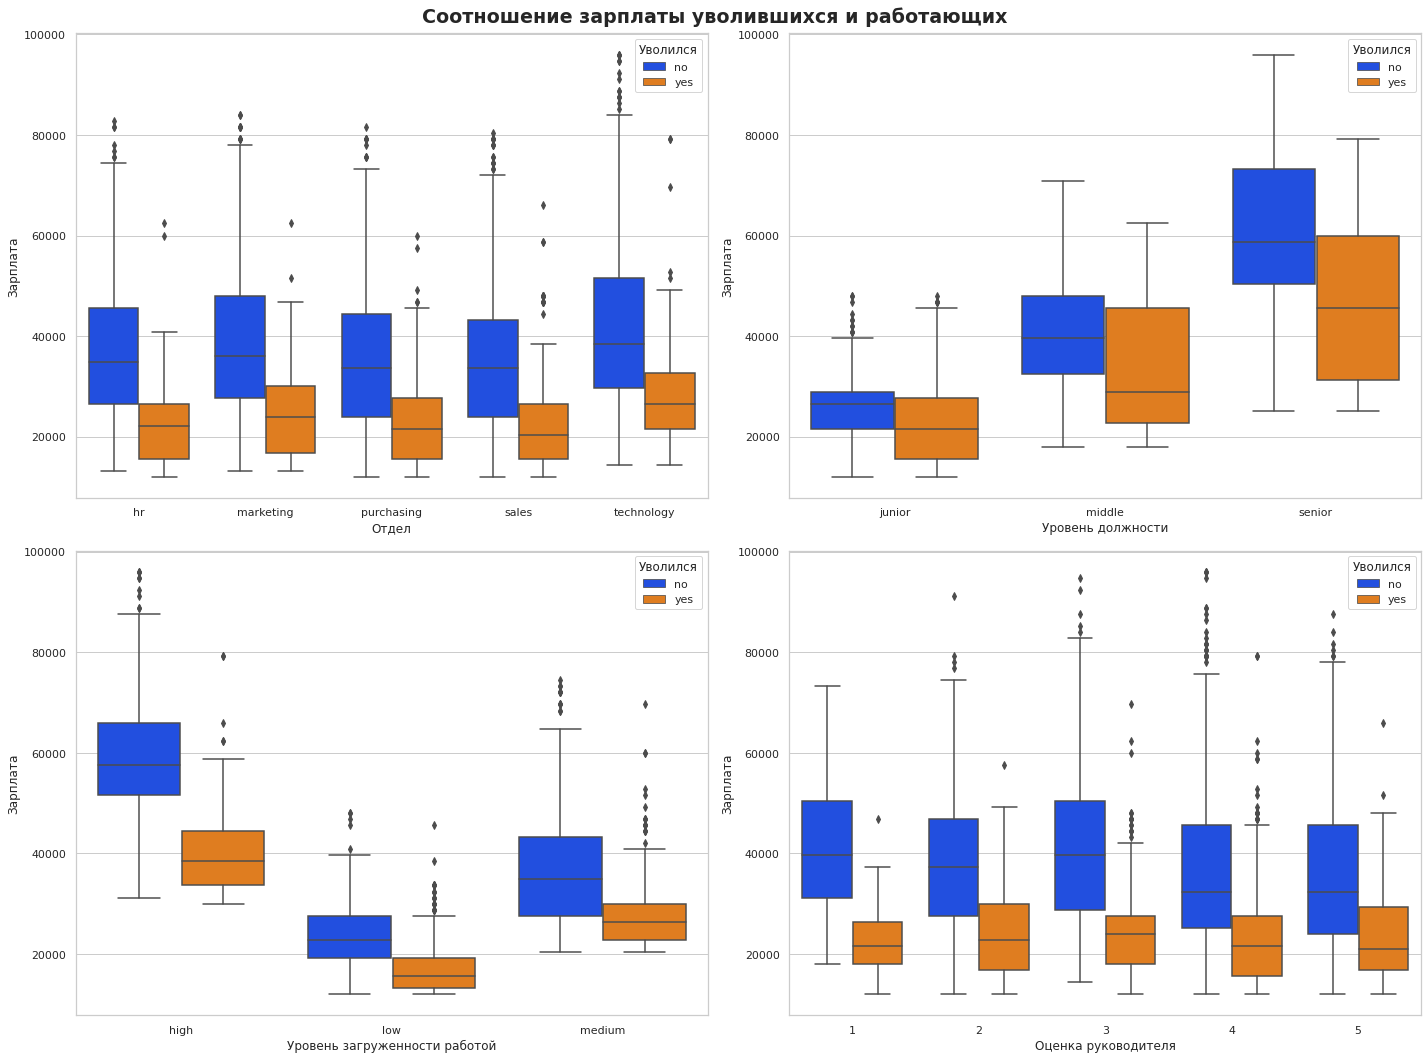

In [42]:
features = ['dept', 'level', 'workload', 'supervisor_evaluation']
x_labels = ['Отдел', 'Уровень должности', 'Уровень загруженности работой', 'Оценка руководителя']

# Настройка сетки графиков
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.suptitle('Соотношение зарплаты уволившихся и работающих', fontsize=19, fontweight='bold')

# Построение графиков через цикл
for i, (feature, xlabel) in enumerate(zip(features, x_labels)):
    row = i // 2  # Определяем строку
    col = i % 2   # Определяем столбец
    ax = sns.boxplot(x=feature, y='salary', hue='quit', palette='bright', data=train_jsr_2, ax=axes[row, col])
    axes[row, col].set(xlabel=xlabel, ylabel='Зарплата')
    axes[row, col].legend(title='Уволился')

plt.tight_layout()
plt.show()

#### Промежуточный вывод

Так выглядит портрет "уволившегося сотрудника":

Из столбчатой диаграммы мы выяснили, что:
* больше всего увольнений из отдела продаж
- работник имеет уровень квалификации junior
- мало или средне загружен (вероятно не чувствует роста в навыках)
- имеет средние оценки руководителя
- работает в компании меньше 1-2 лет
- чаще не нарушает трудовой договор

Из сведений о зарплате, представленной на диаграмме "ящика с усами":
* зарплаты примерно одинаковые в разных отделах, но
- зарплаты уволившихся ниже, чем тех, кто продолжает работать
- это справедливо для всех уровней загруженности и оценок руководителя

Таким образом, типичный уволенный сотрудник, скорее всего, это недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой.

### Корелляция между уровнем удовлетворенности и увольнением

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Добавим в тестовую выборку с целевым признаком 'quit' целевой признак из первой задачи (удовлетворенность работой) и проведем корреляцию между ними.

In [43]:
sat_test = X_test_2
sat_test['job_satisfaction_rate'] = y_test_jsr['job_satisfaction_rate']
sat_test['quit'] = y_test_jsr_2['quit']

Посмотрим что получилось, построим для наглядности два графика в одном:
* сотрудник не уволился в зависимости от удовлетворенности работой
- сотрудник уволился

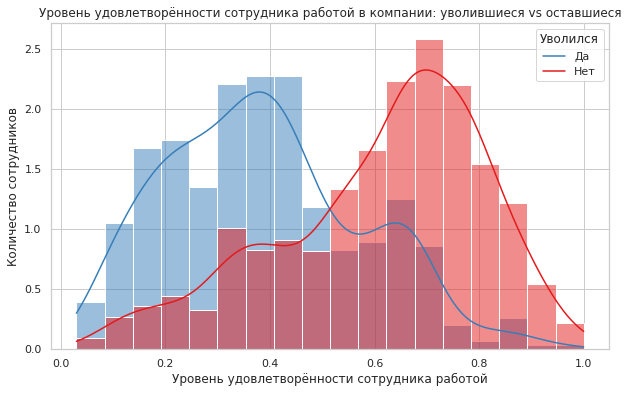

In [44]:
# Построение совмещенного графика
plt.figure(figsize=(10, 6))
sns.histplot(x='job_satisfaction_rate', hue='quit', data=sat_test, kde=True, palette='Set1', hue_norm=[0,100],stat='density', common_norm=False, multiple='layer')
plt.xlabel('Уровень удовлетворённости сотрудника работой')
plt.ylabel('Количество сотрудников')
plt.title('Уровень удовлетворённости сотрудника работой в компании: уволившиеся vs оставшиеся')
plt.legend(title='Уволился', labels=['Да', 'Нет'])
plt.show()

Мы видим, что влияние есть. Чаще увольняются работники с низкой удовлетворенностью работой. Проверим дополнительно для бОльшей достоверности статистическим тестом.

Сформулируем гипотезы:
* Нулевая гипотеза: Средний уровень удовлетворённости работой у уволившихся сотрудников не ниже, чем у оставшихся.

- Альтернативная гипотеза: Средний уровень удовлетворённости работой у уволившихся сотрудников ниже, чем у оставшихся.

In [45]:
#выделим оставшихся и уволившихся работников в отдельные датафреймы
quit_no = sat_test.query(' quit == "no" ')['job_satisfaction_rate']
quit_yes = sat_test.query(' quit == "yes" ')['job_satisfaction_rate']
alpha = 0.05

results = st.ttest_ind(quit_yes, quit_no, alternative ='less' )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средний уровень удовлетворённости уволившихся сотрудников ниже.')
else:
    print('Не отвергаем нулевую гипотезу: нет статистически значимых различий в уровне удовлетворённости.')

p-значение: 6.155610332585965e-105
Отвергаем нулевую гипотезу: средний уровень удовлетворённости уволившихся сотрудников ниже.


In [46]:
# удалим явные дубликаты в тренировочной и тестовой выборках
train_jsr_2.drop_duplicates()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...
778735,technology,junior,low,2,no,no,4,22800,yes
106936,marketing,junior,low,1,no,no,5,18000,no
775320,technology,junior,high,1,no,no,4,42000,yes


#### Промежуточный вывод по EDA (з2)

 Мы провели исследовательский анализ данных, посмотрели распределение нового признака "увольнение", составили портрет "типичного" увольняющегося сотрудника (недавно работающий не загруженный работой junior, которого не очень ценит руководитель, с низкой зарплатой). Также в ходе проверки утверждения отдела аналитики "уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник" мы склоняемся, что уровень удовлетворенности действительно влияет. Уволившиеся сотрудники имели более низкий уровень удовлетворенности.

## Добавление нового входного признака

Добавим признак удовлетворенности работой в наши выборки: тестовую и тренировочную. Для этого воспользуемся нашей лучшей моделью из первой задачи. Получим предсказания удовлетворенности и добавим в виде дополнительного столбца в тестовую и тренировочную выборки.

In [47]:
train_jsr_2['job_satisfaction_rate'] =  randomized_search.predict(train_jsr_2.drop(['quit'], axis=1))
X_test_2['job_satisfaction_rate'] = randomized_search.predict(X_test_2)

## Подготовка данных и обучение модели

Тут достаточно обновить только столбцы, пайплайны были написаны в предыдущей задаче. Поэтому сможем сразу приступить к обучению модели.

In [48]:
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

X_train2 = train_jsr_2.drop(['quit'], axis = 1)
y_train2 = train_jsr_2['quit']

In [49]:
# кодирование целевого признака
le = LabelEncoder()


y_train_encoded = le.fit_transform(y_train2)
y_test_encoded = le.transform(y_test_jsr_2['quit'])

# Проверяем результат
print("Закодированные значения y_train:", y_train_encoded)
print("Закодированные значения y_test:", y_test_encoded)

Закодированные значения y_train: [0 0 0 ... 1 0 1]
Закодированные значения y_test: [1 0 0 ... 0 0 1]


In [50]:
# обучение модели
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [51]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid2, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train2, y_train_encoded)

# сразу получим лучшую модель, параметры, метрику
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                   

In [52]:
X_test_2 = X_test_2.sort_index()
y_test_jsr_2 = y_test_jsr_2.sort_index()
# теперь прогоняем модель на тестовых данных
y_predict_proba = randomized_search.predict_proba(X_test_2)
roc_auc_score(y_test_jsr_2['quit'], y_predict_proba[:, 1])

0.9255362363934492

In [53]:
dummy_cl = DummyClassifier()
dummy_cl.fit(X_train2, y_train2)
y_predict_proba2 = dummy_cl.predict_proba(X_test_2)
roc_auc_score(y_test_jsr_2['quit'], y_predict_proba2[:, 1])

0.5

#### Промежуточный вывод по обучению модели

Мы завершили работу над второй задачей и обучили модель предсказывать, уволится сотрудник из компании или нет. Лучшей моделью для этой задачи оказался метод опорных векторов(SVC) (точность предсказаний около 92% на тестовой выборке).

## Общий вывод по работе

Перед нами стояли две ключевые задачи. Первая заключалась в построении модели, способной предсказать уровень удовлетворённости сотрудников на основе предоставленных данных. Это важно для бизнеса, так как удовлетворённость работой напрямую влияет на текучесть кадров, а предсказание оттока сотрудников является одной из приоритетных задач HR-аналитики. Внезапные увольнения, особенно ключевых сотрудников, несут значительные риски для компании. Вторая задача состояла в создании модели, которая могла бы прогнозировать вероятность увольнения сотрудника на основе тех же данных.

Для решения этих задач мы выполнили следующие этапы:

Загрузка и первичный анализ данных:

Мы изучили данные, включая тренировочную выборку (4000 строк) и тестовую (2000 строк). В данных были обнаружены пропуски в колонках, связанных с отделом и должностью, но дубликаты отсутствовали. Форматы данных соответствовали ожидаемым.

Предобработка данных:

Мы проверили данные на наличие ошибок, заменили пустые значения на NaN и убедились в отсутствии аномалий в количественных признаках.

Исследовательский анализ данных (EDA):

Мы проанализировали распределение данных, построили графики и провели корреляционный анализ. Данные выглядели достоверно, значительных выбросов обнаружено не было, а утечки целевого признака не наблюдалось.

Подготовка данных:

Мы создали пайплайны для обработки данных, включая кодирование категориальных признаков, масштабирование числовых данных и обработку пропусков.

Обучение моделей:

Для первой задачи (предсказание уровня удовлетворённости) мы использовали модели линейной регрессии и дерева решений. Лучшей моделью оказалось дерево решений с максимальной глубиной 12 и максимальным числом признаков для разбиения — 10. Модель показала стабильные результаты на тестовой выборке с метрикой SMAPE.

Для второй задачи (предсказание увольнения) мы применили модели логистической регрессии, метода опорных векторов, KNN и дерева решений. Лучшей моделью стал метод опорных векторов, с параметром регуляризации 3, достигнув точности около 92%.

Рекомендации для бизнеса:

Больше всего увольнений происходит в отделах sales. Рекомендуется провести дополнительные опросы в этих отделах.

Большая часть уволившихся — это сотрудники уровня junior с опытом работы от 1 до 2 лет. Следует уделять больше внимания адаптации и поддержке новичков.


Средняя зарплата оставшихся сотрудников на выше, чем у уволившихся. Возможно, стоит пересмотреть уровень оплаты труда.

Таким образом, мы успешно решили обе задачи, предоставив бизнесу инструменты для прогнозирования удовлетворённости сотрудников и их увольнений, а также рекомендации для снижения текучести кадров.